In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from fiona.crs import from_epsg

In [2]:
gdf_residentials = gpd.read_file('../gangnamGu-building-residential.geojson', encoding='utf8', dtype={'USABILITY':str})

In [3]:
gdf_hexagons = gpd.read_file('../hexagon_res_10/hexagons.geojson')

In [4]:
gdf_hexagons_buffer = gdf_hexagons.copy()

In [5]:
center_point = [Point(x,y) for x,y in zip(gdf_hexagons_buffer['x'],gdf_hexagons_buffer['y'])]

In [6]:
gs_center_point = gpd.GeoSeries(center_point)
gs_center_point.crs = from_epsg(4326)
gs_center_point = gs_center_point.to_crs(epsg=5174)

C:\Users\hsg82\AppData\Local\Continuum\anaconda3\envs\hex_analysis\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [7]:
#gdf_hexagons_buffer.crs = from_epsg(4326)
#gdf_hexagons_buffer = gdf_hexagons_buffer.to_crs(epsg=5174)

In [8]:
# make a buffer zone. radius = 400m
gdf_hexagons_buffer['buffer_geometry_400m'] = gs_center_point.buffer(400) 

## Calculate the number of residential buildings and total building area of residential buildings

In [9]:
gdf_residentials.crs = from_epsg(4326)
gdf_residentials = gdf_residentials.to_crs(epsg=5174)

In [10]:
# 01000 단독주택
# 01001 단독주택
single = ['01000','01001']

# 01002 다중주택
# 01003 다가구주택
# 02003 다세대주택
multi = ['01002','01003','02003']

# 02000 공동주택
# 02001 아파트
# 02002 연립주택
flat = ['02000','02001','02002']

# 10202 오피스텔
mxd = ['10202']

# 01004 공관
# 02007 기숙사 
etc = ['01004','02007']

In [11]:
gdf_residentials['USABILITY'].unique()

array(['01000', '02000'], dtype=object)

In [12]:
gdf_single = gdf_residentials.loc[gdf_residentials['USABILITY']=='01000']
gdf_multi = gdf_residentials.loc[gdf_residentials['USABILITY']=='02000']

In [13]:
gdf_residentials.shape

(11833, 15)

In [14]:
gdf_single.shape

(6484, 15)

In [15]:
gdf_multi.shape

(5349, 15)

In [16]:
def count_buildings(polygon, target_buildings):
    '''
    This function is for making a list of buildings that is in a hexagon area.
    -----
    input:
    polygon (Shapely.geometry.Polygon): a hexagon polygon 
    -----
    output:
    precise_matches_list (list): a list of residential buildings
    
    '''
    try:
        buildings_sindex = target_buildings.sindex
        possible_matches_index = list(buildings_sindex.intersection(polygon.bounds))
        possible_matches = target_buildings.iloc[possible_matches_index]
        # extract the list of buildings that is in a hexagon
        precise_matches_list = possible_matches[possible_matches.intersects(polygon)]['UFID'].tolist()
    except:
        # if there is no buildings that matched within a hexagon, return empty list
        precise_matches_list = []
    return precise_matches_list

In [17]:
gdf_hexagons_buffer['single_houses'] = gdf_hexagons_buffer['geometry'].apply(lambda x: count_buildings(x,gdf_single))

In [18]:
gdf_hexagons_buffer['multi_houses'] = gdf_hexagons_buffer['geometry'].apply(lambda x: count_buildings(x,gdf_multi))

In [19]:
gdf_residentials.columns

Index(['USABILITY', 'HEIGHT', 'PNU', 'GRND_FLR', 'UGRND_FLR', 'DONG_NM',
       'COL_ADM_SE', 'UFID', 'BLDG_PNU', 'BD_MGT_SN', 'ARCHAREA', 'TOTALAREA',
       'BC_RAT', 'VL_RAT', 'geometry'],
      dtype='object')

In [20]:
def sum_archarea(house_list):
    total = gdf_residentials.loc[gdf_residentials['UFID'].isin(house_list)]['ARCHAREA'].sum()
    return total

In [21]:
gdf_hexagons_buffer['single_archarea'] = gdf_hexagons_buffer['single_houses'].apply(lambda x: sum_archarea(x))

In [22]:
gdf_hexagons_buffer['multi_archarea'] = gdf_hexagons_buffer['multi_houses'].apply(lambda x: sum_archarea(x))

In [23]:
gdf_hexagons_buffer['single_count'] = gdf_hexagons_buffer['single_houses'].apply(lambda x: len(x))
gdf_hexagons_buffer['multi_count'] = gdf_hexagons_buffer['multi_houses'].apply(lambda x: len(x))

In [24]:
gdf_hexagons_buffer = gdf_hexagons_buffer.drop(['single_houses','multi_houses'], axis=1)

In [25]:
gdf_hexagons_buffer.head()

,index,x,y,geometry,buffer_geometry_400m,single_archarea,multi_archarea,single_count,multi_count
0,8a30e1c8084ffff,127.061695,37.476327,"POLYGON ((127.06230 37.47605, 127.06222 37.476...","POLYGON ((205787.396 441573.113, 205785.470 44...",0.0,0.0,0,0
1,8a30e1c85aaffff,127.067626,37.493522,"POLYGON ((127.06823 37.49324, 127.06815 37.493...","POLYGON ((206310.648 443481.945, 206308.722 44...",0.0,0.0,0,0
2,8a30e1ca126ffff,127.059607,37.523075,"POLYGON ((127.06021 37.52280, 127.06014 37.523...","POLYGON ((205599.520 446761.437, 205597.594 44...",0.0,0.0,0,0
3,8a30e1c88797fff,127.119429,37.463536,"POLYGON ((127.12003 37.46326, 127.11996 37.463...","POLYGON ((210895.957 440158.300, 210894.031 44...",0.0,0.0,0,0
4,8a30e1ca4257fff,127.022375,37.525698,"POLYGON ((127.02298 37.52542, 127.02290 37.526...","POLYGON ((202308.140 447051.285, 202306.214 44...",0.0,0.0,0,0


##  Count the number of public bike stations in a 400 buffer zone of a hexagon

In [26]:
gdf_bike = gpd.read_file('../publicBikeStation.geojson')

In [27]:
gdf_bike.head()

,stationid,gu,address,y,x,lcd_number,qr_number,type,geometry
0,1695,???,??? ??? 14,37.623417,127.066933,NaN,10.0,QR,POINT (127.06693 37.62342)
1,2301,???,????? ??? ???? 134,37.524071,127.021790,10.0,NaN,LCD,POINT (127.02179 37.52407)
2,2302,???,????? ??? ???? ?? 102,37.505581,127.024277,10.0,NaN,LCD,POINT (127.02428 37.50558)
3,2303,???,????? ??? ??? ?? 102,37.511517,127.021477,15.0,NaN,LCD,POINT (127.02148 37.51152)
4,2304,???,????? ??? ??? 626,37.512527,127.035835,10.0,NaN,LCD,POINT (127.03584 37.51253)


In [28]:
gdf_bike.crs = from_epsg(4326)
gdf_bike = gdf_bike.to_crs(epsg=5174)

C:\Users\hsg82\AppData\Local\Continuum\anaconda3\envs\hex_analysis\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [29]:
def count_stations(polygon, stations):
    try:
        station_sindex = stations.sindex
        possible_matches_index = list(station_sindex.intersection(polygon.bounds))
        possible_matches = stations.iloc[possible_matches_index]
        # extract the list of buildings that is in a hexagon
        precise_matches_list = possible_matches[possible_matches.intersects(polygon)]['stationid'].tolist()
    except:
        # if there is no station that matched within a hexagon, return empty list
        precise_matches_list = []
    return len(precise_matches_list)                        

In [30]:
gdf_hexagons_buffer['count_bike_station'] = gdf_hexagons_buffer['buffer_geometry_400m'].apply(lambda x:count_stations(x,gdf_bike))

## Count the number of bus lines

In [31]:
gdf_bus_stop = gpd.read_file('../seoulBusStop.geojson', dtype={'ARS-ID':str})

In [32]:
gdf_bus_stop.head()

,표준ID,ARS-ID,정류장명,X좌표,Y좌표,geometry
0,100000001,1001,종로2가사거리,126.987750,37.569765,POINT (126.98775 37.56977)
1,100000002,1002,창경궁.서울대학교병원,126.996566,37.579183,POINT (126.99657 37.57918)
2,100000003,1003,명륜3가.성대입구,126.998340,37.582671,POINT (126.99834 37.58267)
3,100000004,1004,종로2가.삼일교,126.987613,37.568579,POINT (126.98761 37.56858)
4,100000005,1005,혜화동로터리.여운형활동터,127.001744,37.586243,POINT (127.00174 37.58624)


In [33]:
gdf_bus_stop.crs = from_epsg(4326)
gdf_bus_stop = gdf_bus_stop.to_crs(epsg=5174)

C:\Users\hsg82\AppData\Local\Continuum\anaconda3\envs\hex_analysis\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [34]:
df_bus_line = pd.read_csv('../seoulBusLine.csv')

In [35]:
df_bus_line.head()

,노선ID,노선명,순번,구간ID,정류소ID,ARS-ID,정류소명,X좌표,Y좌표
0,100100124,0017,1,0,102000271,3689,청암자이아파트,126.946517,37.534363
1,100100124,0017,2,102700549,102000204,3298,청암동강변삼성아파트,126.949304,37.533961
2,100100124,0017,3,102700550,102000227,3321,청심경로당,126.950449,37.533744
3,100100124,0017,4,102700551,102000210,3304,원효2동주민센터,126.950904,37.534278
4,100100124,0017,5,102700552,102000212,3306,산천동,126.953984,37.535420


In [36]:
def get_bus_stations(polygon, stations):
    try:
        station_sindex = stations.sindex
        possible_matches_index = list(station_sindex.intersection(polygon.bounds))
        possible_matches = stations.iloc[possible_matches_index]
        # extract the list of buildings that is in a hexagon
        precise_matches_list = possible_matches[possible_matches.intersects(polygon)]['표준ID'].tolist()
    except:
        # if there is no station that matched within a hexagon, return empty list
        precise_matches_list = []
    return precise_matches_list   

In [37]:
gdf_hexagons_buffer['bus_stops'] = gdf_hexagons_buffer['buffer_geometry_400m'].apply(lambda x: get_bus_stations(x,gdf_bus_stop))

In [38]:
def count_bus_lines(bus_stops, lines):
    return len(lines[lines['정류소ID'].isin(bus_stops)]['노선ID'].unique().tolist())

In [39]:
gdf_hexagons_buffer['count_bus_line'] = gdf_hexagons_buffer['bus_stops'].apply(lambda x: count_bus_lines(x,df_bus_line))

In [40]:
gdf_hexagons_buffer.head()

,index,x,y,geometry,buffer_geometry_400m,single_archarea,multi_archarea,single_count,multi_count,count_bike_station,bus_stops,count_bus_line
0,8a30e1c8084ffff,127.061695,37.476327,"POLYGON ((127.06230 37.47605, 127.06222 37.476...","POLYGON ((205787.396 441573.113, 205785.470 44...",0.0,0.0,0,0,1,"[122900052, 122000262, 122000344, 122000326, 1...",8
1,8a30e1c85aaffff,127.067626,37.493522,"POLYGON ((127.06823 37.49324, 127.06815 37.493...","POLYGON ((206310.648 443481.945, 206308.722 44...",0.0,0.0,0,0,2,"[122000128, 122000136, 122000135, 122000134, 1...",16
2,8a30e1ca126ffff,127.059607,37.523075,"POLYGON ((127.06021 37.52280, 127.06014 37.523...","POLYGON ((205599.520 446761.437, 205597.594 44...",0.0,0.0,0,0,1,"[122000068, 122000069, 122000067, 122000066]",10
3,8a30e1c88797fff,127.119429,37.463536,"POLYGON ((127.12003 37.46326, 127.11996 37.463...","POLYGON ((210895.957 440158.300, 210894.031 44...",0.0,0.0,0,0,0,"[122000310, 122000313]",3
4,8a30e1ca4257fff,127.022375,37.525698,"POLYGON ((127.02298 37.52542, 127.02290 37.526...","POLYGON ((202308.140 447051.285, 202306.214 44...",0.0,0.0,0,0,1,"[122000001, 122000638, 122000002, 122000738, 1...",10


In [41]:
gdf_hexagons_buffer = gdf_hexagons_buffer.drop('bus_stops', axis=1)

In [42]:
gdf_hexagons_buffer.head()

,index,x,y,geometry,buffer_geometry_400m,single_archarea,multi_archarea,single_count,multi_count,count_bike_station,count_bus_line
0,8a30e1c8084ffff,127.061695,37.476327,"POLYGON ((127.06230 37.47605, 127.06222 37.476...","POLYGON ((205787.396 441573.113, 205785.470 44...",0.0,0.0,0,0,1,8
1,8a30e1c85aaffff,127.067626,37.493522,"POLYGON ((127.06823 37.49324, 127.06815 37.493...","POLYGON ((206310.648 443481.945, 206308.722 44...",0.0,0.0,0,0,2,16
2,8a30e1ca126ffff,127.059607,37.523075,"POLYGON ((127.06021 37.52280, 127.06014 37.523...","POLYGON ((205599.520 446761.437, 205597.594 44...",0.0,0.0,0,0,1,10
3,8a30e1c88797fff,127.119429,37.463536,"POLYGON ((127.12003 37.46326, 127.11996 37.463...","POLYGON ((210895.957 440158.300, 210894.031 44...",0.0,0.0,0,0,0,3
4,8a30e1ca4257fff,127.022375,37.525698,"POLYGON ((127.02298 37.52542, 127.02290 37.526...","POLYGON ((202308.140 447051.285, 202306.214 44...",0.0,0.0,0,0,1,10


## Count subway lines

In [43]:
gdf_subway_station = gpd.read_file('../seoulSubwayStation.geojson')

In [44]:
gdf_subway_station.head()

,stationID,stationName,Line,y,x,geometry
0,2818,????,8,37.492522,127.118234,POINT (127.11823 37.49252)
1,340,????,3,37.492522,127.118234,POINT (127.11823 37.49252)
2,2535,??3?,5,37.571607,126.991806,POINT (126.99181 37.57161)
3,319,??3?,3,37.571607,126.991806,POINT (126.99181 37.57161)
4,153,??3?,1,37.571607,126.991806,POINT (126.99181 37.57161)


In [45]:
gdf_subway_station = gdf_subway_station.loc[~gdf_subway_station.geometry.isnull()]

In [46]:
gdf_subway_station.crs = from_epsg(4326)
gdf_subway_station = gdf_subway_station.to_crs(epsg=5174)

C:\Users\hsg82\AppData\Local\Continuum\anaconda3\envs\hex_analysis\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [47]:
def count_subway_lines(polygon, stations):
    try:
        station_sindex = stations.sindex
        possible_matches_index = list(station_sindex.intersection(polygon.bounds))
        possible_matches = stations.iloc[possible_matches_index]
        # extract the list of buildings that is in a hexagon
        precise_matches_list = possible_matches[possible_matches.intersects(polygon)]['Line'].unique().tolist()
    except:
        # if there is no station that matched within a hexagon, return empty list
        precise_matches_list = []
    return len(precise_matches_list)  

In [48]:
gdf_hexagons_buffer['count_subway_line'] =  gdf_hexagons_buffer['buffer_geometry_400m'].apply(lambda x: count_subway_lines(x,gdf_subway_station))

## Calculate accessibility score

In [49]:
max_bus_line = gdf_hexagons_buffer['count_bus_line'].max()
max_bike_station = gdf_hexagons_buffer['count_bike_station'].max()
max_subway_station = gdf_hexagons_buffer['count_subway_line'].max()

In [50]:
print(max_bus_line, max_bike_station, max_subway_station)

41 6 3


In [51]:
gdf_hexagons_buffer.head()

,index,x,y,geometry,buffer_geometry_400m,single_archarea,multi_archarea,single_count,multi_count,count_bike_station,count_bus_line,count_subway_line
0,8a30e1c8084ffff,127.061695,37.476327,"POLYGON ((127.06230 37.47605, 127.06222 37.476...","POLYGON ((205787.396 441573.113, 205785.470 44...",0.0,0.0,0,0,1,8,0
1,8a30e1c85aaffff,127.067626,37.493522,"POLYGON ((127.06823 37.49324, 127.06815 37.493...","POLYGON ((206310.648 443481.945, 206308.722 44...",0.0,0.0,0,0,2,16,1
2,8a30e1ca126ffff,127.059607,37.523075,"POLYGON ((127.06021 37.52280, 127.06014 37.523...","POLYGON ((205599.520 446761.437, 205597.594 44...",0.0,0.0,0,0,1,10,0
3,8a30e1c88797fff,127.119429,37.463536,"POLYGON ((127.12003 37.46326, 127.11996 37.463...","POLYGON ((210895.957 440158.300, 210894.031 44...",0.0,0.0,0,0,0,3,0
4,8a30e1ca4257fff,127.022375,37.525698,"POLYGON ((127.02298 37.52542, 127.02290 37.526...","POLYGON ((202308.140 447051.285, 202306.214 44...",0.0,0.0,0,0,1,10,0


In [52]:
gdf_hexagons_buffer['score_bus'] = (gdf_hexagons_buffer['count_bus_line']/max_bus_line) * 5
gdf_hexagons_buffer['score_bike'] = (gdf_hexagons_buffer['count_bike_station']/max_bike_station) * 5
gdf_hexagons_buffer['score_subway'] = (gdf_hexagons_buffer['count_subway_line']/max_subway_station) * 5

In [53]:
gdf_hexagons_buffer['total_score'] = gdf_hexagons_buffer['score_bus'] + gdf_hexagons_buffer['score_bike'] + gdf_hexagons_buffer['score_subway']

In [54]:
gdf_hexagons_buffer['total_score'].max()

12.134146341463413

<AxesSubplot:>

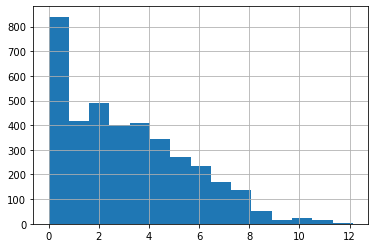

In [55]:
gdf_hexagons_buffer['total_score'].hist(bins=15)

In [56]:
gdf_hexagons_buffer

,index,x,y,geometry,buffer_geometry_400m,single_archarea,multi_archarea,single_count,multi_count,count_bike_station,count_bus_line,count_subway_line,score_bus,score_bike,score_subway,total_score
0,8a30e1c8084ffff,127.061695,37.476327,"POLYGON ((127.06230 37.47605, 127.06222 37.476...","POLYGON ((205787.396 441573.113, 205785.470 44...",0.0,0.0,0,0,1,8,0,0.975610,0.833333,0.000000,1.808943
1,8a30e1c85aaffff,127.067626,37.493522,"POLYGON ((127.06823 37.49324, 127.06815 37.493...","POLYGON ((206310.648 443481.945, 206308.722 44...",0.0,0.0,0,0,2,16,1,1.951220,1.666667,1.666667,5.284553
2,8a30e1ca126ffff,127.059607,37.523075,"POLYGON ((127.06021 37.52280, 127.06014 37.523...","POLYGON ((205599.520 446761.437, 205597.594 44...",0.0,0.0,0,0,1,10,0,1.219512,0.833333,0.000000,2.052846
3,8a30e1c88797fff,127.119429,37.463536,"POLYGON ((127.12003 37.46326, 127.11996 37.463...","POLYGON ((210895.957 440158.300, 210894.031 44...",0.0,0.0,0,0,0,3,0,0.365854,0.000000,0.000000,0.365854
4,8a30e1ca4257fff,127.022375,37.525698,"POLYGON ((127.02298 37.52542, 127.02290 37.526...","POLYGON ((202308.140 447051.285, 202306.214 44...",0.0,0.0,0,0,1,10,0,1.219512,0.833333,0.000000,2.052846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3817,8a30e1c8c6a7fff,127.104353,37.475843,"POLYGON ((127.10495 37.47556, 127.10488 37.476...","POLYGON ((209560.754 441522.726, 209558.827 44...",0.0,0.0,0,0,1,12,0,1.463415,0.833333,0.000000,2.296748
3818,8a30e1c8c8dffff,127.098984,37.487739,"POLYGON ((127.09959 37.48746, 127.09951 37.488...","POLYGON ((209084.468 442842.448, 209082.542 44...",0.0,0.0,0,0,3,18,2,2.195122,2.500000,3.333333,8.028455
3819,8a30e1ca0847fff,127.027548,37.520363,"POLYGON ((127.02815 37.52008, 127.02808 37.520...","POLYGON ((202765.587 446459.264, 202763.661 44...",0.0,0.0,0,0,2,10,0,1.219512,1.666667,0.000000,2.886179
3820,8a30e1c8e567fff,127.095261,37.461287,"POLYGON ((127.09586 37.46101, 127.09579 37.461...","POLYGON ((208758.160 439906.328, 208756.234 43...",0.0,0.0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000


In [57]:
gdf_hexagons_buffer = gdf_hexagons_buffer.drop('buffer_geometry_400m', axis=1)

In [58]:
gdf_hexagons_buffer.to_file('../hexagon_res_10_400m_count/hexagon_with_data.geojson', driver='GeoJSON', encoding='utf8')

In [59]:
gdf_hexagons_buffer.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3822 entries, 0 to 3821
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   index               3822 non-null   object  
 1   x                   3822 non-null   float64 
 2   y                   3822 non-null   float64 
 3   geometry            3822 non-null   geometry
 4   single_archarea     3822 non-null   float64 
 5   multi_archarea      3822 non-null   float64 
 6   single_count        3822 non-null   int64   
 7   multi_count         3822 non-null   int64   
 8   count_bike_station  3822 non-null   int64   
 9   count_bus_line      3822 non-null   int64   
 10  count_subway_line   3822 non-null   int64   
 11  score_bus           3822 non-null   float64 
 12  score_bike          3822 non-null   float64 
 13  score_subway        3822 non-null   float64 
 14  total_score         3822 non-null   float64 
dtypes: float64(8), geometry(1), in